<a href="https://colab.research.google.com/github/rchabo/projet_DDEFi_2025/blob/main/Drive_Mid_term_project_Groupe2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des bibilothèques

In [ ]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c098d6ab9f1f99fd1812966089d087ad4ae30dfb4de8c48422d4da6992f8a6c7
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_datareader.data as web
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import TimeSeriesSplit #Pour la validation croisée temporelle

from ta.momentum import RSIIndicator
from ta.trend import MACD

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

import seaborn as sns

# Partie 1 : Collecte et Préparation des Données

### 1. Collecte des données (+++) :

○ Récupérez les données historiques du S&P 500 (prix de clôture, volume) sur une période de 5 ans via une API (Yahoo Finance ou Alpha Vantage).


In [ ]:
#dates voulues
start_date = '2019-12-19'
end_date = '2024-12-19'
time_interval = '1d'

In [ ]:
#télechargement avec yfinance

# Télécharger les données historiques du S&P 500
symbol = '^GSPC'
sp500_all = yf.download(symbol, start=start_date, end=end_date, interval=time_interval)
sp500 = sp500_all[['Adj Close','Volume']]

# Aplatir les colonnes si elles ont un index multi-niveaux
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = ['_'.join(col).strip() for col in sp500.columns]

[*********************100%***********************]  1 of 1 completed


○ Ajoutez des variables exogènes (VIX, taux d'intérêt, indicateurs économiques).

In [ ]:
# Télécharger les données de l'indice VIX depuis Yahoo Finance
vix = yf.download('^VIX', start=start_date, end=end_date, interval='1d')
vix = vix[['Adj Close']]
vix = vix.rename(columns={'Adj Close': 'VIX'})

# Aplatir les colonnes si elles ont un index multi-niveaux
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns]


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Télécharger des indicateurs économiques via pandas_datareader (FRED)

# Exemple 1 : Taux de chômage (UNRATE)
unemployment_data = web.DataReader('UNRATE', 'fred', start_date, end_date)
unemployment_data.rename(columns={'UNRATE': 'Unemployment_Rate'}, inplace=True)
unemployment_data = unemployment_data.rename_axis('Date')

# Exemple 2 : Taux des fonds fédéraux (FEDFUNDS)
fed_funds_data = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
fed_funds_data.rename(columns={'FEDFUNDS': 'Fed_Funds_Rate'}, inplace=True)
fed_funds_data = fed_funds_data.rename_axis('Date')

# Exemple 3 : Indice des prix à la consommation (CPIAUCSL)
cpi_data = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
cpi_data.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
cpi_data = cpi_data.rename_axis('Date')

# Exemple 4 : Ventes au détail (RSAFS)
retail_sales_data = web.DataReader('RSAFS', 'fred', start_date, end_date)
retail_sales_data.rename(columns={'RSAFS': 'Retail_Sales'}, inplace=True)
retail_sales_data = retail_sales_data.rename_axis('Date')

# Exemple 5 : Indice de confiance des consommateurs (UMCSENT)
consumer_confidence_data = web.DataReader('UMCSENT', 'fred', start_date, end_date)
consumer_confidence_data.rename(columns={'UMCSENT': 'Consumer_Confidence_Index'}, inplace=True)
consumer_confidence_data = consumer_confidence_data.rename_axis('Date')

# Exemple 6 : indice de production industrielle
industrial_production = web.DataReader('INDPRO', 'fred', start_date, end_date)
industrial_production = industrial_production.rename(columns={'INDPRO': 'Industrial_Production'})
industrial_production = industrial_production.rename_axis('Date')

# Exemple 7 : taux d'intérêt des bons du Trésor à 10 ans
treasury_yield_10y = web.DataReader('DGS10', 'fred', start_date, end_date)
treasury_yield_10y = treasury_yield_10y.rename(columns={'DGS10': '10Y_Treasury_Yield'})
treasury_yield_10y = treasury_yield_10y.rename_axis('Date')

Création de la table avec des jointures :

In [ ]:
#Fusionner les données de clotures et de volume avec les taux à 10 ans
data = sp500.merge(treasury_yield_10y, left_index=True, right_index=True, how='left')

#Fusionner l'indice VIX
data = data.merge(vix, left_index=True, right_index=True, how='left')

#Fusionner l'indice de production
data = data.merge(industrial_production, left_index=True, right_index=True, how='left')

# Fusionner les données du taux de chômage avec suffixes pour éviter les doublons
data = data.merge(unemployment_data, left_index=True, right_index=True, how='left')

# Fusionner les données du taux des fonds fédéraux avec suffixes pour éviter les doublons
data = data.merge(fed_funds_data, left_index=True, right_index=True, how='left', suffixes=('', '_fed_funds'))

# Fusionner les données de l'indice des prix à la consommation (CPI) avec suffixes pour éviter les doublons
data = data.merge(cpi_data, left_index=True, right_index=True, how='left', suffixes=('', '_cpi'))

# Fusionner les données des ventes au détail avec suffixes pour éviter les doublons
data = data.merge(retail_sales_data, left_index=True, right_index=True, how='left', suffixes=('', '_retail_sales'))

# Fusionner les données de l'indice de confiance des consommateurs avec suffixes pour éviter les doublons
data = data.merge(consumer_confidence_data, left_index=True, right_index=True, how='left', suffixes=('', '_consumer_confidence'))

display(data.tail())


,Adj Close_^GSPC,Volume_^GSPC,10Y_Treasury_Yield,VIX_^VIX,Industrial_Production,Unemployment_Rate,Fed_Funds_Rate,CPI,Retail_Sales,Consumer_Confidence_Index
Date,,,,,,,,,,
2024-12-12,6051.250000,3678010000,4.32,13.920000,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-13,6051.089844,3584960000,4.40,13.810000,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-16,6074.080078,4391100000,4.39,14.690000,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-17,6050.609863,4544500000,4.40,15.870000,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-18,5872.160156,5246960000,4.50,27.620001,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Prétraitement des données (++) :

In [ ]:
#informations sur les éléments
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-12-19 to 2024-12-18
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Adj Close_^GSPC            1258 non-null   float64
 1   Volume_^GSPC               1258 non-null   int64  
 2   10Y_Treasury_Yield         1249 non-null   float64
 3   VIX_^VIX                   1258 non-null   float64
 4   Industrial_Production      41 non-null     float64
 5   Unemployment_Rate          41 non-null     float64
 6   Fed_Funds_Rate             41 non-null     float64
 7   CPI                        41 non-null     float64
 8   Retail_Sales               41 non-null     float64
 9   Consumer_Confidence_Index  41 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 108.1 KB


<Axes: ylabel='Date'>

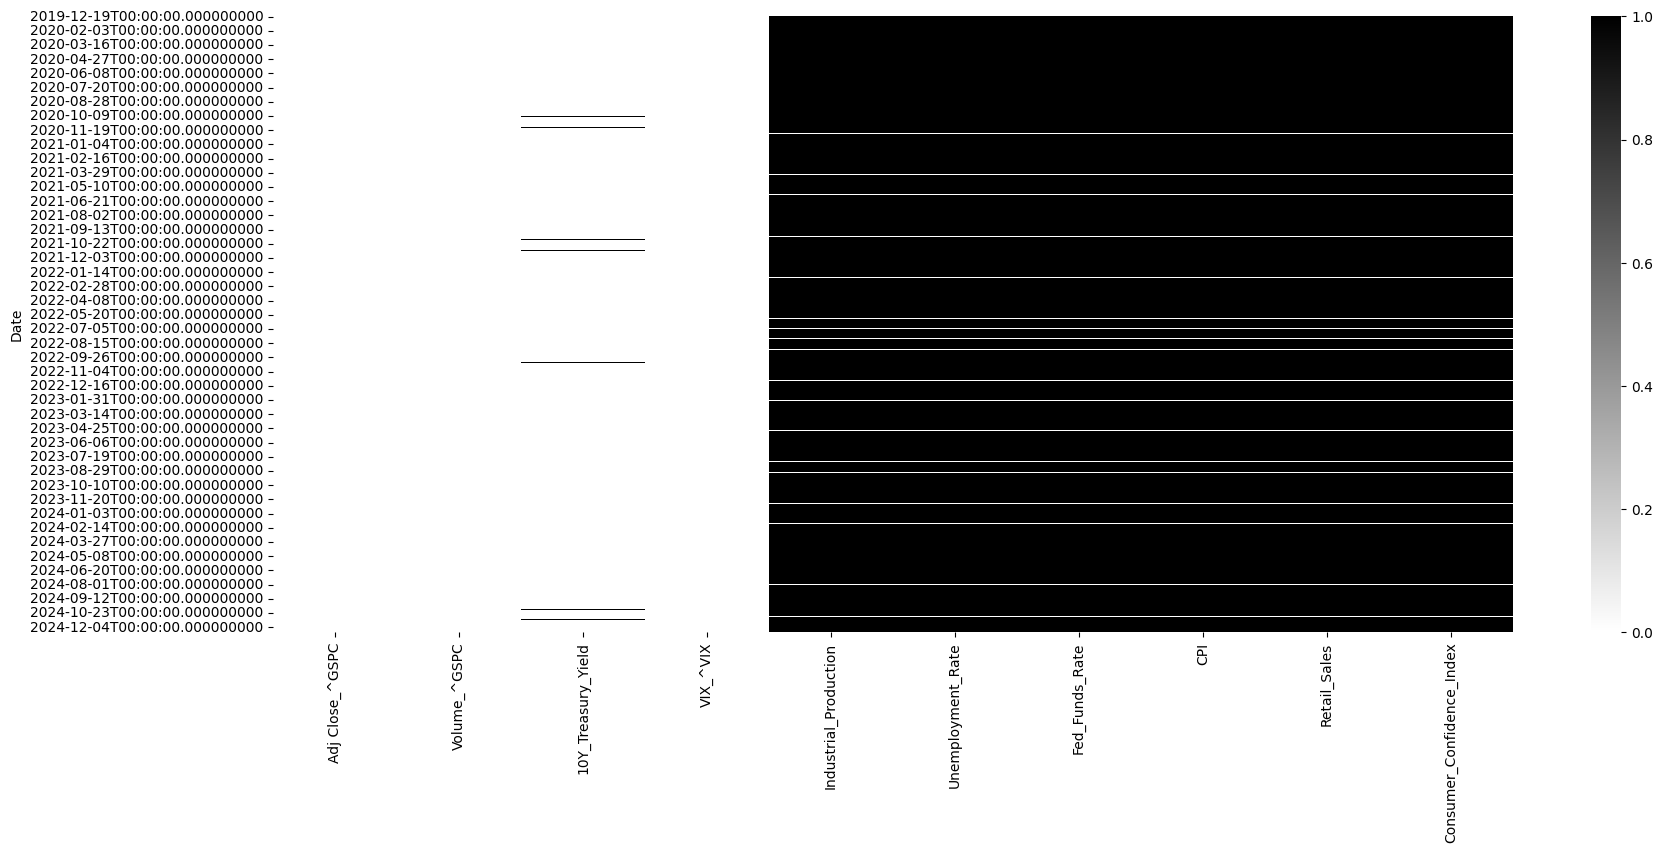

In [ ]:
#Visualisation des données manquantes
plt.figure(figsize=(20, 8))
sns.heatmap(data.isnull(),cmap='binary',)

Nettoyez les données (valeurs manquantes, doublons):


In [ ]:
# Remplacer les valeurs manquantes avec une interpolation linéaire
data['10Y_Treasury_Yield'] = data['10Y_Treasury_Yield'].interpolate()

#Propager des données mensuelles pour qu'elles soient journalières
data = data.ffill()
data = data.bfill()

# Supprimer les lignes en double
data = data.drop_duplicates()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-12-19 to 2024-12-18
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Adj Close_^GSPC            1258 non-null   float64
 1   Volume_^GSPC               1258 non-null   int64  
 2   10Y_Treasury_Yield         1258 non-null   float64
 3   VIX_^VIX                   1258 non-null   float64
 4   Industrial_Production      1258 non-null   float64
 5   Unemployment_Rate          1258 non-null   float64
 6   Fed_Funds_Rate             1258 non-null   float64
 7   CPI                        1258 non-null   float64
 8   Retail_Sales               1258 non-null   float64
 9   Consumer_Confidence_Index  1258 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 108.1 KB


In [ ]:
data.describe()

,Adj Close_^GSPC,Volume_^GSPC,10Y_Treasury_Yield,VIX_^VIX,Industrial_Production,Unemployment_Rate,Fed_Funds_Rate,CPI,Retail_Sales,Consumer_Confidence_Index
count,1258.000000,1.258000e+03,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,4242.275407,4.374503e+09,2.672579,21.384936,99.581298,5.610890,2.353903,287.385301,632402.435612,70.093879
std,759.766901,1.044988e+09,1.387677,8.278955,5.271926,3.257687,2.366655,21.070963,85402.116505,8.706524
min,2237.399902,1.296530e+09,0.520000,11.860000,84.681200,3.500000,0.050000,255.848000,408312.000000,50.000000
25%,3804.542542,3.751010e+09,1.422500,15.850000,98.203900,3.700000,0.080000,264.910000,612647.000000,64.200000
50%,4197.549805,4.111105e+09,2.910000,19.629999,102.112300,4.000000,1.210000,294.977000,671067.000000,70.500000
75%,4586.782593,4.711380e+09,3.987500,24.855000,102.902400,6.100000,5.080000,307.288000,698105.000000,76.900000
max,6090.270020,9.976520e+09,4.980000,82.690002,103.532600,14.800000,5.330000,316.441000,724609.000000,88.300000


Transformez les prix en rendements log (log-returns) :


In [ ]:
# Calcul des rendements logarithmiques
data['Log_Returns'] = np.log(data['Adj Close_^GSPC'] / data['Adj Close_^GSPC'].shift(1))

# remplacer la première valeur NaN dans la colonne
data['Log_Returns'] = data['Log_Returns'].fillna(data['Log_Returns'].median())

data.head()

,Adj Close_^GSPC,Volume_^GSPC,10Y_Treasury_Yield,VIX_^VIX,Industrial_Production,Unemployment_Rate,Fed_Funds_Rate,CPI,Retail_Sales,Consumer_Confidence_Index,Log_Returns
Date,,,,,,,,,,,
2019-12-19,3205.370117,3784360000,1.92,12.50,84.6812,14.8,0.05,256.126,408312.0,71.8,0.000903
2019-12-20,3221.219971,6457480000,1.92,12.51,84.6812,14.8,0.05,256.126,408312.0,71.8,0.004933
2019-12-23,3224.010010,3064530000,1.93,12.61,84.6812,14.8,0.05,256.126,408312.0,71.8,0.000866
2019-12-24,3223.379883,1296530000,1.90,12.67,84.6812,14.8,0.05,256.126,408312.0,71.8,-0.000195
2019-12-26,3239.909912,2164540000,1.90,12.65,84.6812,14.8,0.05,256.126,408312.0,71.8,0.005115


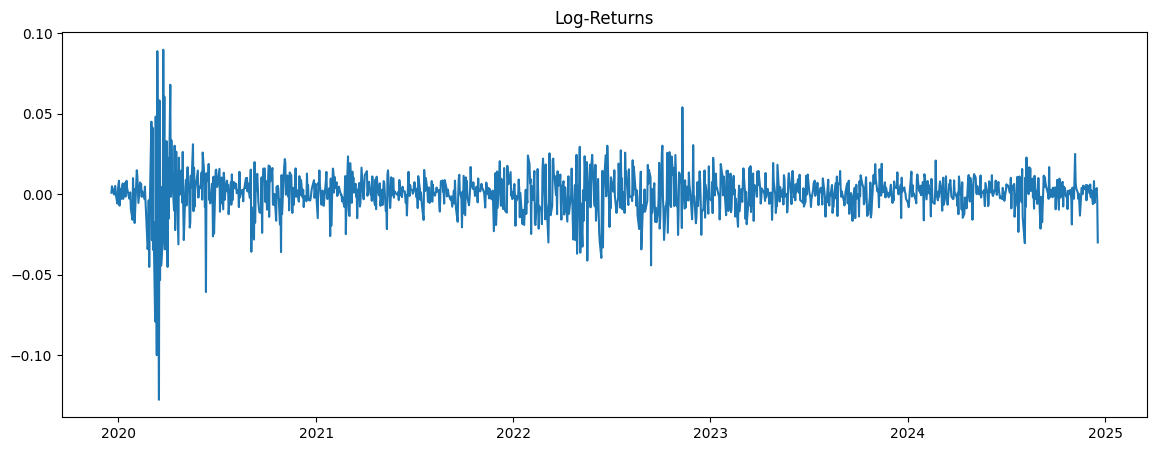

In [ ]:
plt.figure(figsize = (14,5))
plt.plot(data.index,data['Log_Returns'])
plt.title('Log-Returns')
plt.show()

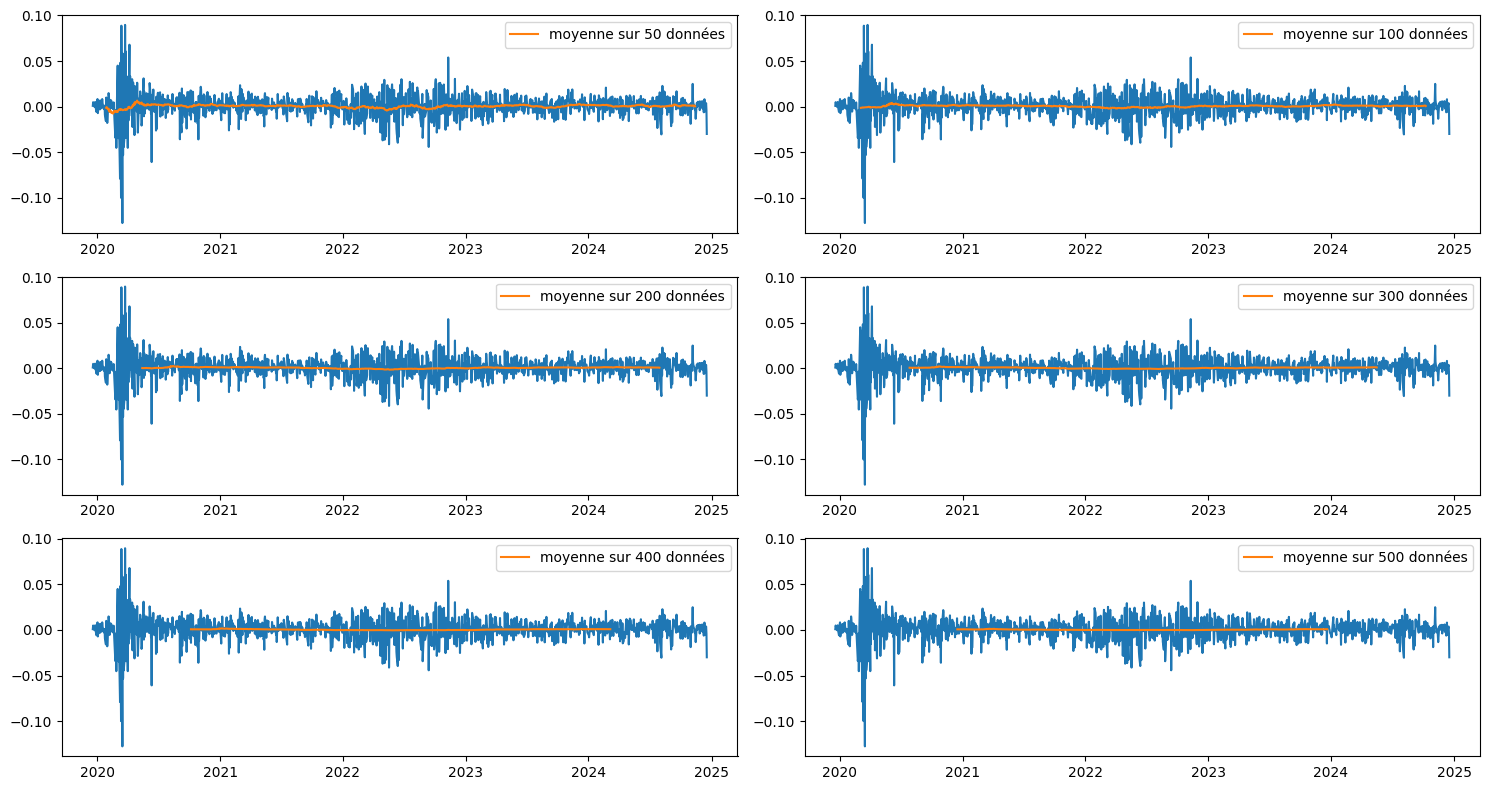

In [ ]:
win = [50, 100, 200, 300, 400, 500]
fig = plt.figure(figsize=(15,8))

for i in range(len(win)):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(data['Log_Returns'])
    ax.plot(data['Log_Returns'].rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} données")
    ax.legend()
    plt.tight_layout()
plt.show()

*On n'observe pas de saisonalité ou de motif particuliers : pas de différenciation à faire dans le modèle ARIMA*

Effectuez une analyse de stationnarité (test ADF) et déterminez les décalages temporels pertinents.

In [ ]:
# Test de stationnarité (ADF - Augmented Dickey-Fuller test)
result = adfuller(data['Log_Returns'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -10.591317597986174
p-value: 6.5168231600469545e-19


Le test de Dickey-Fuller rejette l'hypothèse nulle, la série est donc stationnaire

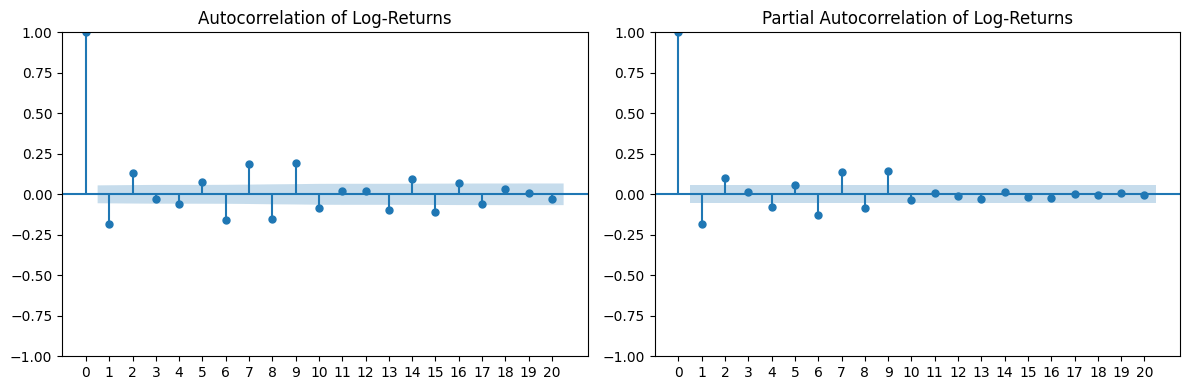

In [ ]:
# Tracer l'ACF des log-rendements avec une plage de lags plus grande (par exemple 20)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(121)
plot_acf(data['Log_Returns'], lags=20, ax=plt.gca(), title="Autocorrelation of Log-Returns")
plt.xticks(np.arange(0, 21, 1))

# Tracer la PACF des log-rendements avec une plage de lags plus grande (par exemple 20)
plt.subplot(122)
plot_pacf(data['Log_Returns'], lags=20, ax=plt.gca(), title="Partial Autocorrelation of Log-Returns")
plt.xticks(np.arange(0, 21, 1))

plt.tight_layout()
plt.show()

### 3. Feature engineering (+) :

Créez des indicateurs techniques (Moyennes mobiles, RSI, MACD).

<Axes: ylabel='Date'>

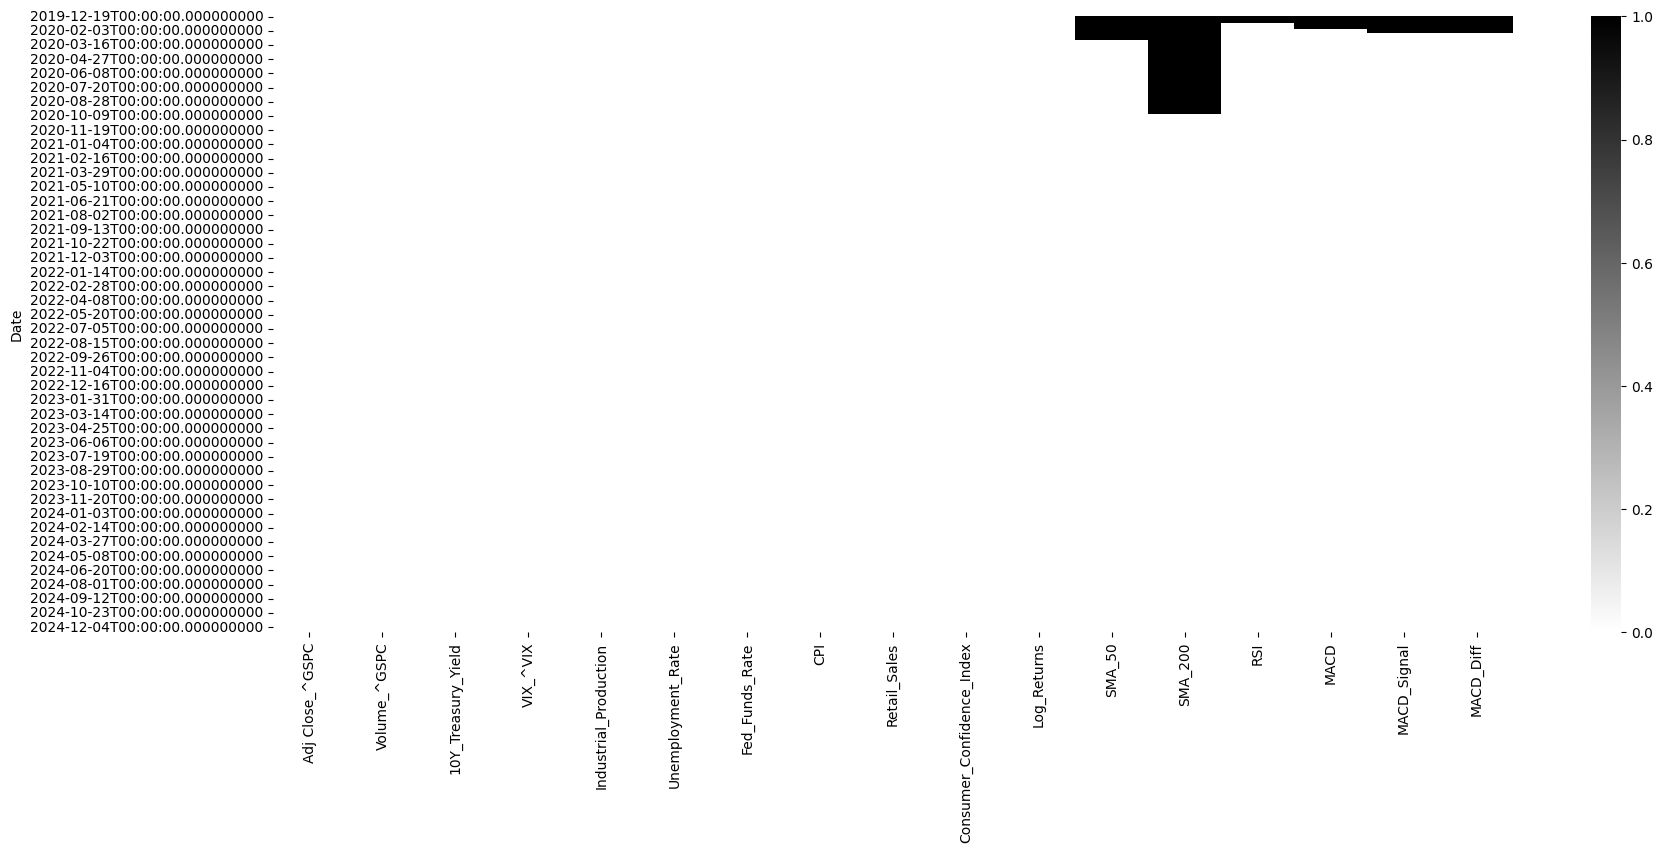

In [ ]:
# Ajouter des moyennes mobiles
data['SMA_50'] = data['Adj Close_^GSPC'].rolling(window=50).mean()
data['SMA_200'] = data['Adj Close_^GSPC'].rolling(window=200).mean()

# Ajouter le RSI (Relative Strength Index)
rsi = RSIIndicator(data['Adj Close_^GSPC'])
data['RSI'] = rsi.rsi()

# Ajouter le MACD (Moving Average Convergence Divergence)
macd = MACD(sp500['Adj Close_^GSPC'])
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['MACD_Diff'] = macd.macd_diff()

#Visualisation des données manquantes
plt.figure(figsize=(20, 8))
sns.heatmap(data.isnull(),cmap='binary',)

In [ ]:
# Supprimer les lignes avec NaN
data.dropna(inplace=True)

#remplir les données manquantes avce la valeur moyenne
data['SMA_50'] = data['SMA_50'].fillna(data['SMA_50'].mean())
data['SMA_200'] = data['SMA_200'].fillna(data['SMA_200'].mean())
data['RSI'] = data['RSI'].fillna(data['RSI'].mean())
data['MACD'] = data['MACD'].fillna(data['MACD'].mean())
data['MACD_Signal'] = data['MACD_Signal'].fillna(data['MACD_Signal'].mean())
data['MACD_Diff'] = data['MACD_Diff'].fillna(data['MACD_Diff'].mean())

Identifiez les variables clés avec des techniques de corrélation ou de sélection de features

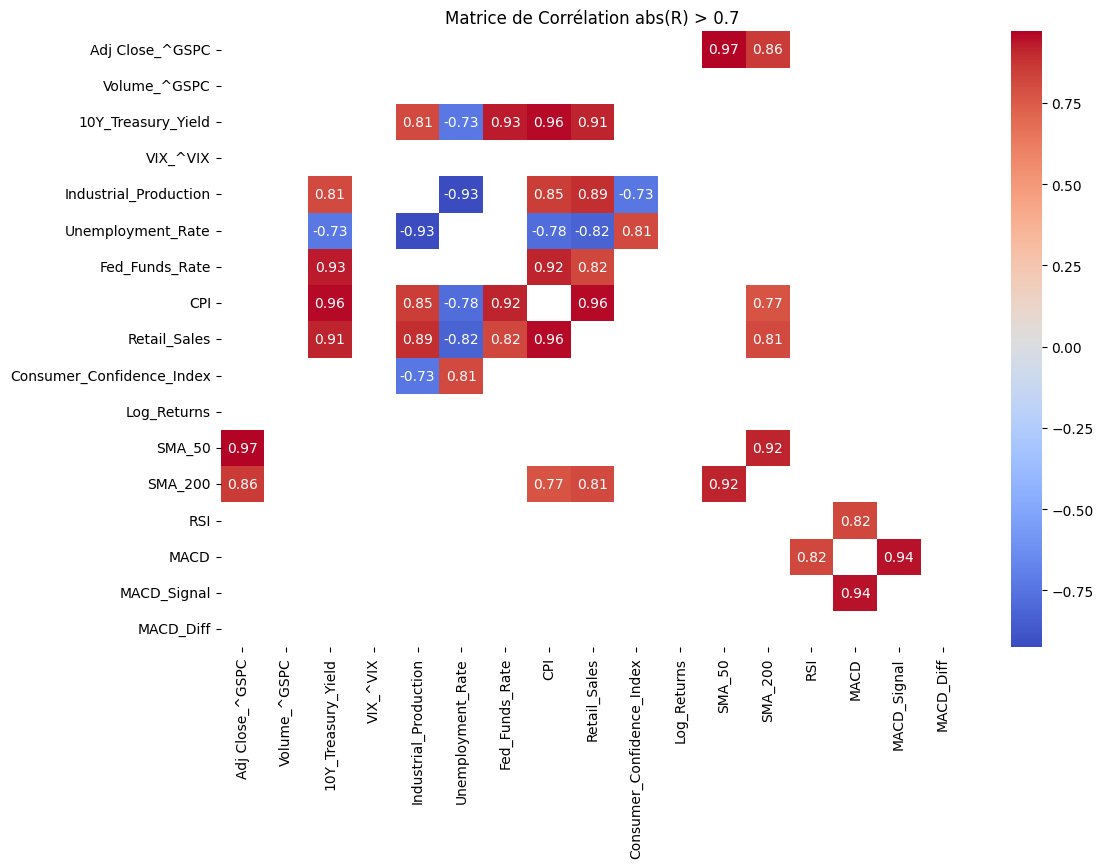

In [ ]:
# Analyse de corrélation
correlation_matrix = data.corr()

# Masque pour ne garder que les corrélations supérieures à 0.7 en valeur absolue
mask = (correlation_matrix.abs() > 0.7) & (correlation_matrix != 1)  # Ne pas inclure les corrélations parfaites

# Appliquer le masque à la matrice de corrélation
filtered_corr = correlation_matrix[mask]

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation abs(R) > 0.7')
plt.show()

On ne garde que les corrélations dont la veleur absolue dépasse 0.7

In [ ]:
# Définir les variables indépendantes (features) et la variable dépendante (target)
X = data[['Adj Close_^GSPC', 'Volume_^GSPC', '10Y_Treasury_Yield', 'VIX_^VIX',
            'Unemployment_Rate', 'Fed_Funds_Rate', 'CPI', 'Retail_Sales',
            'Consumer_Confidence_Index', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff']]
y = data[['Adj Close_^GSPC']]

# Appliquer SelectKBest pour choisir les meilleures features
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Afficher les scores des features
scores = np.abs(selector.scores_)
sum = np.sum(scores)
features = X.columns

feature_scores = pd.DataFrame({'Feature': features, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print("Scores des features avec SelectKBest:")
print(feature_scores)

Scores des features avec SelectKBest:
                      Feature         Score
0             Adj Close_^GSPC  4.989837e+15
9                      SMA_50  1.716521e+04
10                    SMA_200  2.903410e+03
6                         CPI  7.193717e+02
7                Retail_Sales  7.048655e+02
3                    VIX_^VIX  5.454870e+02
5              Fed_Funds_Rate  3.604260e+02
2          10Y_Treasury_Yield  3.214506e+02
13                MACD_Signal  1.660940e+02
12                       MACD  1.519688e+02
11                        RSI  1.035453e+02
1                Volume_^GSPC  9.456049e+01
4           Unemployment_Rate  9.446997e+01
8   Consumer_Confidence_Index  3.851444e+00
14                  MACD_Diff  1.469552e+00


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Utilisation du modèle RFE

In [ ]:
#nombre de variables à retenir
n_features_to_select = 5

In [ ]:
# Créer le modèle de régression linéaire
model = LinearRegression()

# Appliquer RFE pour sélectionner les meilleures features
rfe = RFE(model, n_features_to_select=n_features_to_select)
fit = rfe.fit(X, y)

# Afficher les résultats de la sélection
selected_features = X.columns[fit.support_]
print("Features sélectionnées par RFE:")
print(selected_features)

Features sélectionnées par RFE:
Index(['Adj Close_^GSPC', '10Y_Treasury_Yield', 'Unemployment_Rate',
       'Fed_Funds_Rate', 'Consumer_Confidence_Index'],
      dtype='object')


In [ ]:
#Varaibles utilisées pour les modèles
selected_features

Index(['Adj Close_^GSPC', '10Y_Treasury_Yield', 'Unemployment_Rate',
       'Fed_Funds_Rate', 'Consumer_Confidence_Index'],
      dtype='object')

# Partie 2 : Développement du Modèle Prédictif

In [ ]:
#Pour simplifier l'appel
time_series = data['Log_Returns']

In [ ]:
# Préparer les features et la target
target = ['Log_Returns']
features = selected_features
X = data[features]
y = data[target]

### 1. Choix des modèles :

Implémentez au moins deux modèles parmi les suivants :
*   Régression linéaire pour les rendements. +++
*   Modèle ARIMA pour les séries temporelles stationnaires.


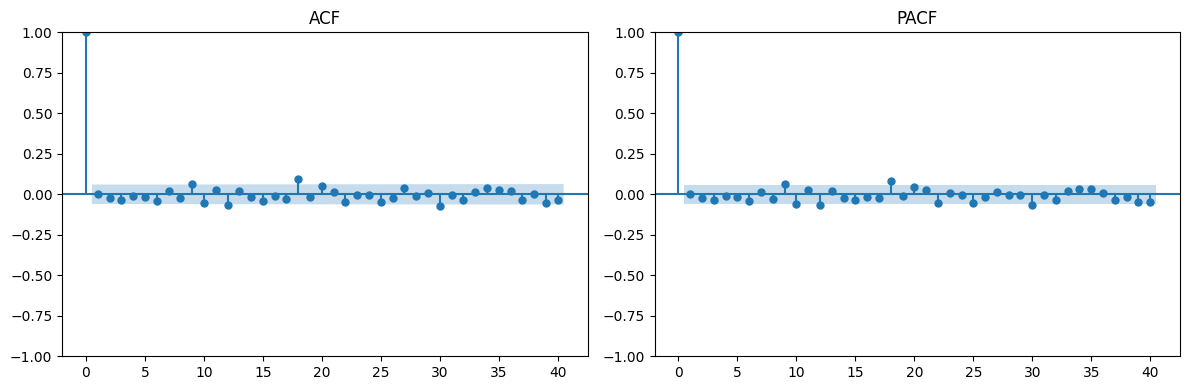

In [ ]:
#Modèle ARIMA

# Analyse ACF/PACF pour déterminer les paramètres p, q
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(time_series, lags=40, ax=plt.gca())
plt.title('ACF')
plt.tight_layout()

plt.subplot(122)
plot_pacf(time_series, lags=40, ax=plt.gca())
plt.title('PACF')
plt.tight_layout()

plt.show()

In [ ]:
#On peut déduire de l'ACF et de la PACF p=2 et q=3 par exemple.
#On a donc un modèle ARMA(2,3)

model_arima = ARIMA(time_series, order=(2, 0, 3))
model_arima_fit = model_arima.fit()

# Résumé du modèle
print(model_arima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Log_Returns   No. Observations:                 1059
Model:                 ARIMA(2, 0, 3)   Log Likelihood                3333.377
Date:                Fri, 03 Jan 2025   AIC                          -6652.754
Time:                        14:31:20   BIC                          -6617.998
Sample:                             0   HQIC                         -6639.581
                               - 1059                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.686      0.092   -8.56e-05       0.001
ar.L1         -0.2378      0.548     -0.434      0.664      -1.311       0.836
ar.L2          0.5560      0.368      1.510      0.1

In [ ]:
# Trouver le meilleur modèle ARIMA automatiquement
time_series_diff = time_series.diff().dropna() # Différenciation manuelle pour que auto_arima puisse trouver un bon modèle
model_auto_arima = auto_arima(
    time_series_diff,
    seasonal=False,         # Si la série n'est pas saisonnière
    max_p=5,                # Limite de p
    max_q=5,                # Limite de q
)

# Résumé du modèle sélectionné
print(model_auto_arima.summary())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1058
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3319.227
Date:                Fri, 03 Jan 2025   AIC                          -6626.454
Time:                        14:31:52   BIC                          -6596.669
Sample:                             0   HQIC                         -6615.165
                               - 1058                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7617      0.217     -3.509      0.000      -1.187      -0.336
ar.L2         -0.0363      0.033     -1.105      0.269      -0.101       0.028
ar.L3         -0.0624      0.027     -2.282      0.0

Les deux modèles ont des AIC, BIC et Log Likelihood semblables cependant le modèle obtenu avec la fonction auto_arima possède davantage de coefficients significatifs.

### 2. Entraînement et validation :

Séparez les données en ensemble d’entraînement (80%) et de test (20%) cf
Pareto.
○ Utilisez une validation croisée temporelle (rolling window).
○ Évaluez les modèles avec les métriques suivantes :

*   MAE (Mean Absolute Error)
*   RMSE (Root Mean Squared Error)
*   Accuracy si vous prédisez les directions (hausse/baisse).




MAE moyen : 0.0098
RMSE moyen : 0.0126


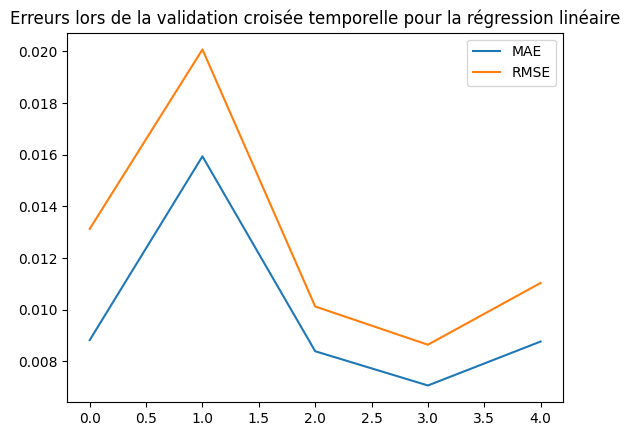

In [ ]:
#Entraînement et validation du modèle avec la régression linéaire

# Créer le modèle de régression linéaire
model_lineaire = LinearRegression()

# Validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entraîner le modèle
    model_lineaire.fit(X_train, y_train)

    # Faire des prédictions
    y_pred = model_lineaire.predict(X_test)

    # Calculer les métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

#On prend la moyenne sur les différents splits
print(f"MAE moyen : {np.mean(mae_scores):.4f}")
print(f"RMSE moyen : {np.mean(rmse_scores):.4f}")

plt.plot(np.arange(0,len(mae_scores)), mae_scores)
plt.plot(np.arange(0,len(rmse_scores)), rmse_scores)
plt.legend(['MAE','RMSE'])
plt.title('Erreurs lors de la validation croisée temporelle pour la régression linéaire')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

MAE moyen : 0.0078
RMSE moyen : 0.0101


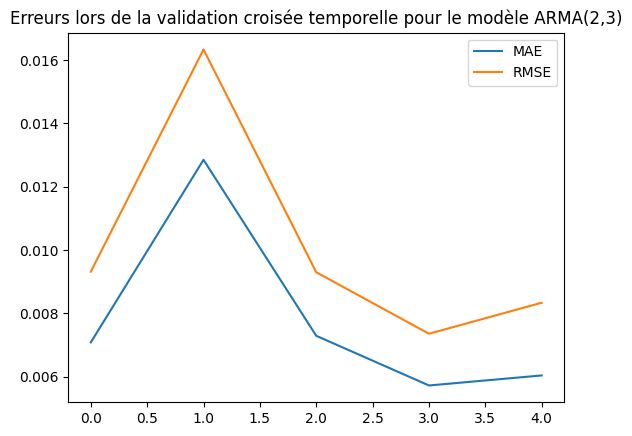

In [ ]:
#Entraînement et validation du modèle ARMA(2,3)

# Validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []

for train_index, test_index in tscv.split(time_series):
    train, test = time_series.iloc[train_index], time_series.iloc[test_index]

    # Faire des prédictions sur l'ensemble de test
    forecast = model_arima_fit.forecast(steps=len(test))

    # Calculer les métriques MAE et RMSE
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

# Résultats globaux
print(f"MAE moyen : {np.mean(mae_scores):.4f}")
print(f"RMSE moyen : {np.mean(rmse_scores):.4f}")

plt.plot(np.arange(0,len(mae_scores)), mae_scores)
plt.plot(np.arange(0,len(rmse_scores)), rmse_scores)
plt.legend(['MAE','RMSE'])
plt.title('Erreurs lors de la validation croisée temporelle pour le modèle ARMA(2,3)')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

MAE moyen : 0.0078
RMSE moyen : 0.0101


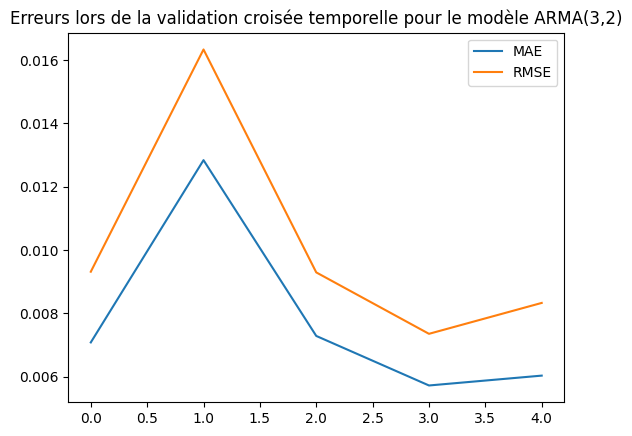

In [ ]:
model_arima_2 = ARIMA(time_series, order=(3, 0, 2))
model_arima_2_fit = model_arima_2.fit()

#Entraînement et validation du modèle ARMA(3,2)

# Validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []

for train_index, test_index in tscv.split(time_series):
    train, test = time_series.iloc[train_index], time_series.iloc[test_index]

    # Faire des prédictions sur l'ensemble de test
    forecast = model_arima_2_fit.forecast(steps=len(test))

    # Calculer les métriques MAE et RMSE
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

# Résultats globaux
print(f"MAE moyen : {np.mean(mae_scores):.4f}")
print(f"RMSE moyen : {np.mean(rmse_scores):.4f}")

plt.plot(np.arange(0,len(mae_scores)), mae_scores)
plt.plot(np.arange(0,len(rmse_scores)), rmse_scores)
plt.legend(['MAE','RMSE'])
plt.title('Erreurs lors de la validation croisée temporelle pour le modèle ARMA(3,2)')
plt.show()

# Partie 3 : Analyse des Résultats et Interprétation

### 1. Analyse des performances :

### 2. Discussion sur les erreurs courantes :

### 3. Conclusion et recommandations :